In [1]:
# Data and Numbers
import pandas as pd
import numpy as np
import datetime as dt

# Modeling

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score,precision_recall_curve,f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler



# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Load the data

In [3]:
fintechs = pd.read_csv('fintechs.csv')

In [4]:
fintechs.columns

Index(['uuid', 'country_code', 'region', 'city', 'status', 'category_list',
       'category_groups_list', 'num_funding_rounds', 'total_funding_usd',
       'founded_on', 'employee_count', 'num_exits', 'investment_type',
       'investor_count', 'year_founded', 'avg_amount_raised', 'success_age',
       'binary_status'],
      dtype='object')

# Modeling

### Set up features and target= binary status
- The first step is to convert 'empoyee_count' and 'investment_type' columns with values like '1-10', '101-250' and 'angel', 'seed' respectively into ordinal values.
- Then to create dummy variables and merge them in the feature matrix.

In [5]:
fintechs['employee_count'].unique()

array(['101-250', '251-500', '501-1000', '1-10', '1001-5000', '10000+',
       '11-50', '51-100', '5001-10000', 'unknown'], dtype=object)

In [6]:
employee_order = {
    '1-10': 1,
    '11-50': 2,
    '51-100': 3,
    '101-250': 4,
    '251-500': 5,
    '501-1000': 6,
    '1001-5000': 7,
    '5001-10000': 8,
    '10000+': 9,
    'unknown': -1
}

In [7]:
fintechs['employee_count_ord'] = fintechs['employee_count'].map(employee_order)

In [8]:
order = {
    'pre_seed': 1,
    'seed': 2,
    'angel': 3,
    'series_a': 4,
    'series_b': 5,
    'series_c': 6,
    'series_d': 7,
    'series_e': 8,
    'series_f': 9,
    'series_g': 10,
    'series_h': 11,
    'series_i': 12,
    'series_j': 13
}

In [9]:
fintechs['investment_type_ord'] = fintechs['investment_type'].map(order)

In [10]:
# Category Dummies
cat_dummies = pd.get_dummies(fintechs['category_groups_list'], drop_first=True)
# Region Dummies
region_dummies = pd.get_dummies(fintechs['region'], drop_first=True)
# Country Dummies
country_dummies = pd.get_dummies(fintechs['country_code'], drop_first=True)

In [11]:
X_col_nodummies = [
    'num_funding_rounds', 'total_funding_usd', 'employee_count_ord',
       'investment_type_ord', 'investor_count', 'avg_amount_raised'
]
X_nodummies = fintechs[X_col_nodummies]

In [12]:
# Merge in dummies to feature matrix
X = X_nodummies.merge(cat_dummies, left_index=True, right_index=True).merge(
    region_dummies, left_index=True, right_index=True).merge(country_dummies,
                                                              left_index=True,
                                                              right_index=True)

In [13]:
# Target
y = fintechs['binary_status']

## Feature interaction

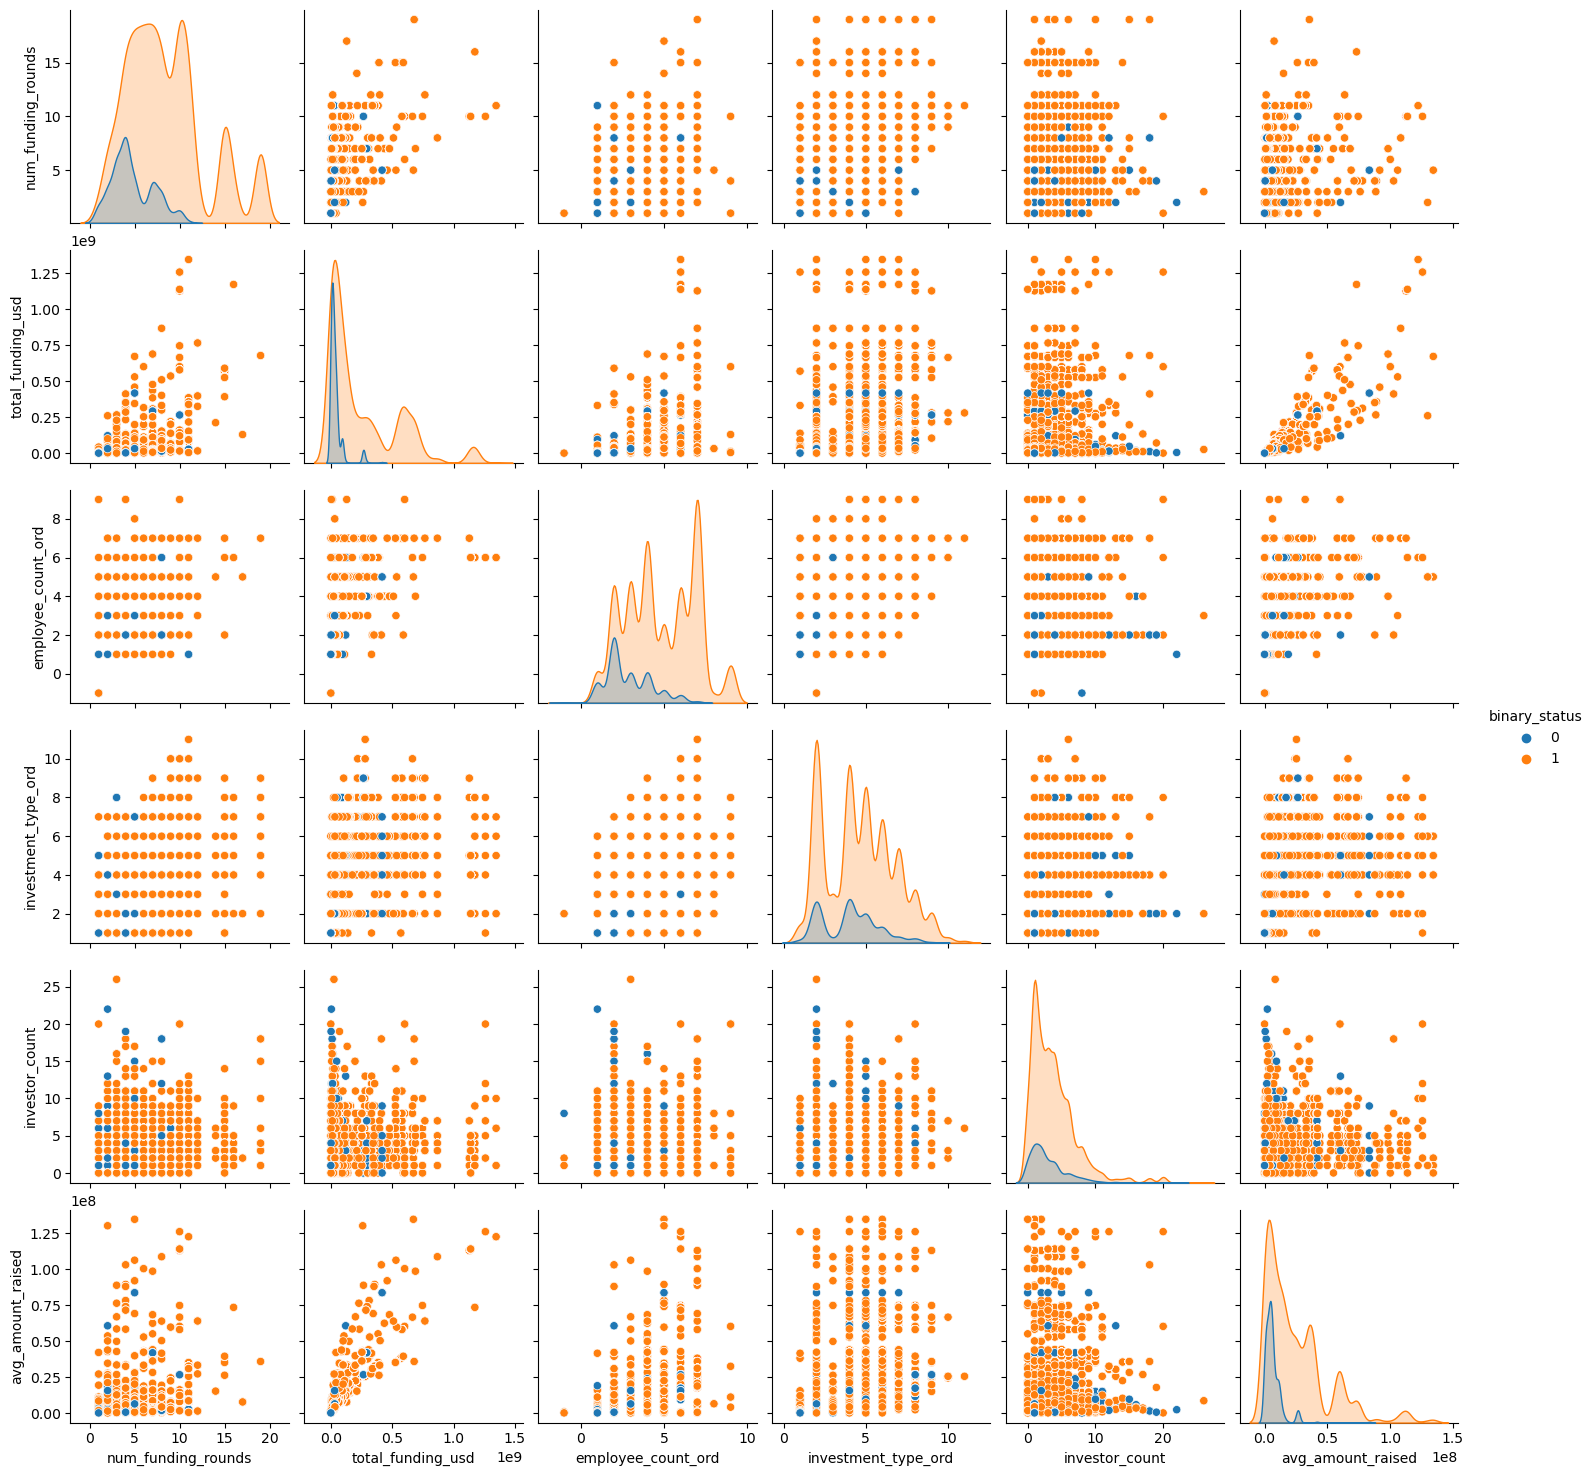

In [14]:
sns.pairplot(fintechs[X_col_nodummies + ['binary_status']], hue='binary_status')

C:\Users\Pc\AppData\Local\Temp\ipykernel_23432\2009916544.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fintechs[fintechs.binary_status == 0]['investor_count'],
C:\Users\Pc\AppData\Local\Temp\ipykernel_23432\2009916544.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fintechs[fintechs.binary_status == 1]['investor_count'],


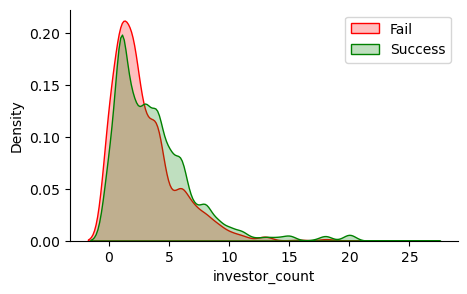

In [15]:
# Investor count
plt.figure(figsize=(5,3))
sns.kdeplot(fintechs[fintechs.binary_status == 0]['investor_count'],
            label='Fail',
            shade=True,
            color='red')
sns.kdeplot(fintechs[fintechs.binary_status == 1]['investor_count'],
            label='Success',
            shade=True,
            color='green')
sns.despine()
plt.legend()
plt.savefig('investors.png')

C:\Users\Pc\AppData\Local\Temp\ipykernel_23432\3313933259.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fintechs[fintechs.binary_status == 0]['avg_amount_raised'],
C:\Users\Pc\AppData\Local\Temp\ipykernel_23432\3313933259.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fintechs[fintechs.binary_status == 1]['avg_amount_raised'],


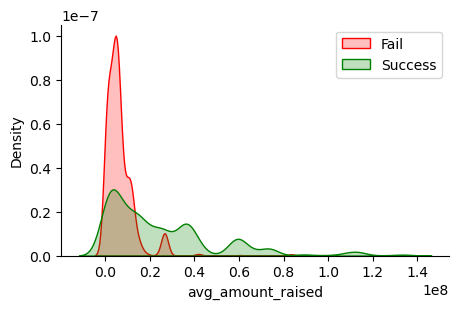

In [16]:
# Avarage funding amount
plt.figure(figsize=(5,3))
sns.kdeplot(fintechs[fintechs.binary_status == 0]['avg_amount_raised'],
            label='Fail',
            shade=True,
            color='red')
sns.kdeplot(fintechs[fintechs.binary_status == 1]['avg_amount_raised'],
            label='Success',
            shade=True,
            color='green')
sns.despine()
plt.legend()
plt.savefig('avg_funding.png')

## Distribution of target ( success/failure)

In [17]:
target_count = y.value_counts()

In [18]:
print(f'Failure: {target_count[0]}')
print(f'Succes: {target_count[1]}')

Failure: 2089
Succes: 11570


## Train test data & Standardize data

In [19]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [20]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

## Random Forest

In [21]:
from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.over_sampling import SMOTE

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
# Create a pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()), # Scale data
    ('smote' , SMOTE(random_state=42)), # Apply SMOTE
    ('classifier', RandomForestClassifier(random_state=42))  # Classifier model
])

In [25]:
# Fit the pipeline to the training data
pipeline.fit(X_test, y_test)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [26]:
# Making predictions
predictions = pipeline.predict(X_test)

In [27]:
# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
print(f"Test set accuracy of the best model: {accuracy * 100:.2f}%")

Test set accuracy of the best model: 100.00%


In [28]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]             } 

In [29]:
# Instantiate the grid search with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=2)


In [30]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]})

In [31]:
# Best parameters found 
print('Best parameters:', grid_search.best_params_)

Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


In [32]:
# Best score achieved
print("Best score:", grid_search.best_score_)

Best score: 0.9888351130418422


In [33]:
# Best estimator
best_model = grid_search.best_estimator_

In [34]:
# Making predictions with the best model
y_pred_rf = best_model.predict(X_test_scaled)

In [35]:
# Evaluating the best model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Test set accuracy of the best model: {accuracy * 100:.2f}%")

Test set accuracy of the best model: 73.28%


In [36]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [37]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.33      0.70      0.44       418
           1       0.93      0.74      0.82      2314

    accuracy                           0.73      2732
   macro avg       0.63      0.72      0.63      2732
weighted avg       0.84      0.73      0.77      2732



## Support Vector Machines - SVM

In [38]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
pipeline_svm = ImbPipeline([
     ('scaler', StandardScaler()), # Scale data
    ('classifier', SVC(random_state=42))  # SVM classifier
])

In [41]:
pipeline.fit(X_test,y_test)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [42]:
svm_predict= pipeline.predict(X_test)

In [43]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

In [44]:
# Grid search
grid = GridSearchCV(pipeline_svm, param_grid)

In [45]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SVC(random_state=42))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf']})

In [46]:
print("Best parameters:", grid.best_params_)


Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


In [47]:
# Best model
best_model = grid.best_estimator_


In [48]:
y_pred_svm= best_model.predict(X_test_scaled)

In [49]:
# Model evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.842606149341142
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       429
           1       0.84      1.00      0.91      2303

    accuracy                           0.84      2732
   macro avg       0.42      0.50      0.46      2732
weighted avg       0.71      0.84      0.77      2732



## XGBoost  

In [50]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [51]:
from xgboost import XGBClassifier

In [52]:
pipeline_xgb = ImbPipeline([
     ('scaler', StandardScaler()), # Scale data
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  # XGBoost classifier
])

In [53]:
# Parameter grid for GridSearchCV
parameter_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 6],
    'classifier__subsample': [0.8, 1],
    'classifier__colsample_bytree': [0.8, 1],
}


In [54]:
grid_search = GridSearchCV(pipeline_xgb, parameter_grid, cv=2, scoring='accuracy', verbose=1)


In [55]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      import...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__colsample_bytree': [0.8, 1],
                         'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 6],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [56]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


In [57]:
best_model_xgboost= grid_search.best_estimator_

In [58]:
y_pred_xgb= best_model_xgboost.predict(X_test)

In [59]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(classification_report(y_test, y_pred_xgb))

Accuracy: 0.986090775988287
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       429
           1       0.99      1.00      0.99      2303

    accuracy                           0.99      2732
   macro avg       0.98      0.96      0.97      2732
weighted avg       0.99      0.99      0.99      2732



In [60]:
print(f"Model accuracy: {accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")

Model accuracy: 98.61%


# The most influential features and models comparison

In [61]:
best_model_xgb= grid_search.best_estimator_['classifier']

In [62]:
feature_importances = best_model_xgb.feature_importances_


In [63]:
xgb_features =pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)


In [64]:
top_20_features = xgb_features[0:20]
pd.set_option('display.max_colwidth', None)  # Set to None to display full content of each cell
pd.set_option('display.max_rows', None) 

In [65]:
print(top_20_features)

                                                                                                                                          feature  \
597                                                                                                                                           USA   
304                                                                         Financial Services,Information Technology,Mobile,Privacy and Security   
5                                                                                                                               avg_amount_raised   
527                                                                                                                                Stockholms Lan   
303                                                                            Financial Services,Information Technology,Mobile,Payments,Software   
269                                                                                                       

In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)

In [68]:
# Define a function to calculate TPR, TNR, FPR, FNR from a confusion matrix
def calculate_rates(cm,decimals=4):
    tn, fp, fn, tp = cm.ravel()
    tpr = round(tp / (tp + fn), decimals)  # True Positive Rate
    tnr = round(tn / (tn + fp), decimals)  # True Negative Rate
    fpr = round(fp / (fp + tn), decimals)  # False Positive Rate
    fnr = round(fn / (tp + fn), decimals) # False Negative Rate
    return tpr, tnr, fpr, fnr

In [69]:
rates_xgb = calculate_rates(cm_xgb)
rates_rf = calculate_rates(cm_rf)
rates_svm = calculate_rates(cm_svm)

In [70]:
print("XGBoost TPR, TNR, FPR, FNR:", rates_xgb)
print("Random Forest TPR, TNR, FPR, FNR:", rates_rf)
print("SVM TPR, TNR, FPR, FNR:", rates_svm)

XGBoost TPR, TNR, FPR, FNR: (0.997, 0.9277, 0.0723, 0.003)
Random Forest TPR, TNR, FPR, FNR: (0.6687, 0.3054, 0.6946, 0.3313)
SVM TPR, TNR, FPR, FNR: (0.9996, 0.0, 1.0, 0.0004)


### The ideal model would have high TPR and TNR values and low FPR and FNR values, indicating it accurately classifies the positive and negative cases while minimizing errors. However, the trade-offs between these metrics often depend on the specific application and the relative costs of false positives versus false negatives.